# 14. Bandpass filtering

In [1]:
import scipy.io
from matplotlib import pyplot as plt

#import basic functions from numpy that we'll need
from numpy import pi, sin, cos, exp, sqrt, log, log10, random, angle, real, imag  
from numpy import zeros, ceil, floor, absolute, linspace
import numpy as np
from numpy.fft import fft, ifft
from scipy import signal as sig
from scipy.signal import hilbert
from scipy.signal import firls
from scipy.stats.mstats import zscore

### Figure 14.1

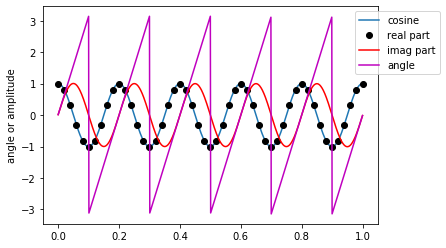

In [2]:
#create cosine
time = np.arange(0,1+0.001,0.001)
cosine = cos(2*pi*5*time)

#plot the signal, and the real & imaginary part of its hilbert transform, and the angle of the analytic signal
plt.plot(time,cosine)
plt.plot(time[::20],real(hilbert(cosine[::20])),'ko') #plot every 20th point bc of overlap
plt.plot(time,imag(hilbert(cosine)),'r')
plt.plot(time,angle(hilbert(cosine)),'m')

plt.ylabel("angle or amplitude")
_=plt.legend(['cosine','real part','imag part','angle'],bbox_to_anchor=[1.2,1])

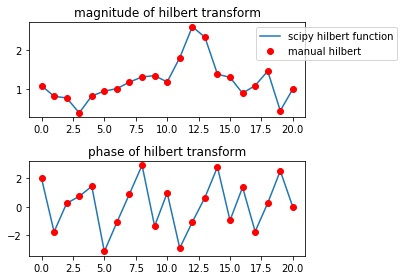

In [3]:
#The FFT-based hilbert transform

#generate random numbers
n = 21
randomnumbers = random.randn(21)

#take FFT
f = fft(randomnumbers)

#create copy that is multiplied by complex operator
complexf = 1j*f

#find indices of positive and negatice frequencies
posF = np.arange(1,floor(n/2.) + (n%2)).astype(int)
negF = np.arange(ceil(n/2.) + (~n%2),n).astype(int)

#rotate Fourier coefficients
#note1: this works by computing iAsin(2pft) component, i.e. phase quadrature
#note 2: positive frequencies are rotated counter clockwise, negative frequencies are rotated clockwise

f[posF] = f[posF] + -1j*complexf[posF]
f[negF] = f[negF] +  1j*complexf[negF]

#next two lines are alternative and slightly faster method
#book explains why this is equivalent
# f[posF] = f[posF] * 2
# f[negF] = f[negF] * 0

#take inverse FFT
hilbertx = ifft(f)

#compare with scipy's hilbert function
hilbertm = hilbert(randomnumbers)

#plot results

plt.subplot(211)
plt.plot(absolute(hilbertm))
plt.plot(absolute(hilbertx),'ro')
plt.legend(["scipy hilbert function","manual hilbert"],bbox_to_anchor = [1.35,1])
plt.title("magnitude of hilbert transform")

plt.subplot(212)
plt.plot(angle(hilbertm))
plt.plot(angle(hilbertx),'ro')
plt.title("phase of hilbert transform")

plt.tight_layout()

In [4]:
data = scipy.io.loadmat('../data/sampleEEGdata')
EEGdata = data["EEG"][0,0]["data"]
EEGpnts = data["EEG"][0,0]["pnts"][0,0] #number of points in EEG data
EEGtimes = data["EEG"][0,0]["times"][0]
EEGsrate = float(data["EEG"][0,0]["srate"][0]) #make float for division purposes later
EEGtrials = data["EEG"][0,0]["trials"][0,0]
EEGnbchan = data["EEG"][0,0]["nbchan"][0,0]

EEGchanlocslabels=data["EEG"][0,0]["chanlocs"][0]["labels"]


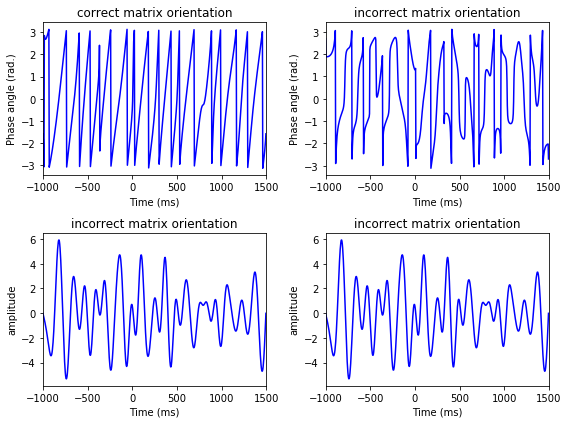

In [5]:
# first, filter data (filter mechanisms will be explained more below; for now, focus on 
# using the phases from the Hilbert transform to test whether the matrix input was correct)


nyquist = EEGsrate//2
lower_filter_bound = 4. #hz
upper_filter_bound = 10. #hz

transition_width = 0.2
filter_order = (3*EEGsrate//lower_filter_bound) + 1

#create filter shape

ffrequencies = np.array([0, (1-transition_width) * lower_filter_bound, 
                        lower_filter_bound, upper_filter_bound, 
                         (1 + transition_width)* upper_filter_bound, nyquist]) / nyquist

idealresponse = np.array([0,0,1,1,0,0])
filterweights = firls(filter_order,ffrequencies,idealresponse) #use firls script described above

#apply the filter kernal to the data to obtain the band-pass filtered signal
filtered_data = zeros([EEGnbchan,EEGpnts])

for chani in range(EEGnbchan):
    filtered_data[chani,:] = sig.filtfilt(filterweights,1,EEGdata[chani,:,0])

#  apply hilbert transform in correct and incorrect orientations
hilbert_oops = hilbert(filtered_data, axis=0);
hilbert_yes  = hilbert(filtered_data,axis=1); #compute it along the last axis 

#  Note that the output of the hilbert transform is transposed to bring us back to an electrode X time matrix.
plt.figure(figsize=[8,6])

plt.subplot(221)
plt.plot(EEGtimes,angle(hilbert_yes[0,:]),'b');
plt.title('correct matrix orientation')
plt.xlabel('Time (ms)'), plt.ylabel('Phase angle (rad.)')
gca =plt.gca()
plt.setp(gca,'xlim',[-1000, 1500])

plt.subplot(222)
plt.plot(EEGtimes,angle(hilbert_oops[0,:]),'b');
plt.title('incorrect matrix orientation')
plt.xlabel('Time (ms)'), plt.ylabel('Phase angle (rad.)')
gca =plt.gca()
plt.setp(gca,'xlim',[-1000, 1500])

plt.subplot(223)
plt.plot(EEGtimes,real(hilbert_yes[0,:]),'b');
plt.title('incorrect matrix orientation')
plt.xlabel('Time (ms)'), plt.ylabel('amplitude')
gca =plt.gca()
plt.setp(gca,'xlim',[-1000, 1500])

plt.subplot(224)
plt.plot(EEGtimes,real(hilbert_oops[0,:]),'b');
plt.title('incorrect matrix orientation')
plt.xlabel('Time (ms)'), plt.ylabel('amplitude')
gca =plt.gca()
plt.setp(gca,'xlim',[-1000, 1500])

plt.tight_layout()

### Figure 14.3

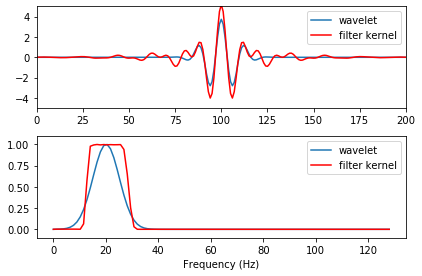

In [6]:

center_freq = 20 #in hz
filter_frequency_spread = 6 #Hz, +- center frequency
wavelet_frequency_spread = 4

#create wavelet
time = np.arange(-1000/EEGsrate/10.,1000/EEGsrate/10. + 1/EEGsrate,1/EEGsrate)

wavelet = exp(2*1j*pi*center_freq*time) * exp(-time**2/(2*(wavelet_frequency_spread/(2*pi*center_freq))**2))
wavelet = zscore(wavelet)

#compute its power spectrum
fft_wavelet = absolute(fft(wavelet))
fft_wavelet /= np.max(fft_wavelet) #normalized to one for visual comparison case

hz_wavelet = np.linspace(0,nyquist,len(time)//2 + 1)

#construct filter kernel

transition_width = 0.2

ffrequencies   = np.array([ 0, (1-transition_width)*(center_freq-filter_frequency_spread),
                  (center_freq-filter_frequency_spread),
                  (center_freq+filter_frequency_spread),
                  (1+transition_width)*(center_freq+filter_frequency_spread),
                  nyquist ])/nyquist


idealresponse = np.array([0,0,1,1,0,0])
filterweights = zscore(firls(201,ffrequencies,idealresponse))

#also compute weights using firwin
filterweights1=zscore(sig.firwin(201,np.array([center_freq-filter_frequency_spread,
                                  center_freq+filter_frequency_spread])/nyquist))

#compute its power spectrum
fft_filtkern = np.absolute(fft(filterweights))
fft_filtkern /=np.max(fft_filtkern) #again normalize to 1 for comparison

fft_filtkern1 = np.absolute(fft(filterweights1))[:-1]
fft_filtkern1 /=np.max(fft_filtkern1)

hz_filtkern = np.linspace(0,nyquist,101) #list of frequencies in hz corresponding to fitler kernel

#plot wavelet and filter kernel
plt.subplot(211)
plt.plot(real(wavelet))
plt.plot(filterweights,'r')
plt.legend(["wavelet","filter kernel"])
plt.setp(plt.gca(),'xlim',[0, 200],'ylim',[-5, 5])

#plot power spectra
plt.subplot(212)
plt.plot(hz_wavelet,fft_wavelet[:int(ceil(len(fft_wavelet)/2.))])
plt.plot(hz_filtkern,fft_filtkern[:int(ceil(len(fft_filtkern)/2.))],'r')
plt.legend(['wavelet','filter kernel'])
plt.setp(plt.gca(),'ylim',[-.1, 1.1])
plt.xlabel('Frequency (Hz)')

plt.tight_layout()


### Figure 14.3

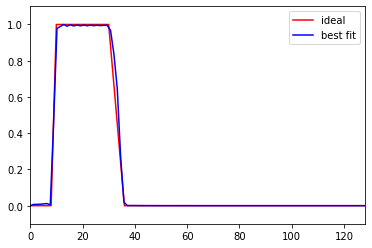

In [7]:
center_freq = 20. #in Hz
filter_frequency_spread_wide = 10 # Hz - center frequency

ffrequencies   = np.array([ 0,
                  (1-transition_width)*(center_freq-filter_frequency_spread_wide),
                  (center_freq-filter_frequency_spread_wide) ,
                  (center_freq+filter_frequency_spread_wide), 
                  (1+transition_width)*(center_freq+filter_frequency_spread_wide) ,
                  nyquist ])/nyquist;

idealresponse = np.array([0,0,1,1,0,0])
filterweightsW = zscore(firls(201,ffrequencies,idealresponse))


plt.plot(ffrequencies*nyquist,idealresponse,'r')


fft_filtkern = absolute(fft(filterweightsW))
fft_filtkern = fft_filtkern/np.max(fft_filtkern) #normalized to 1 for visualization

plt.plot(hz_filtkern,fft_filtkern[:int(ceil(len(fft_filtkern)/2.))],'b')

plt.axis([0,nyquist,-.1,1.1])
_=plt.legend(["ideal",'best fit'])

### Figure 14.5

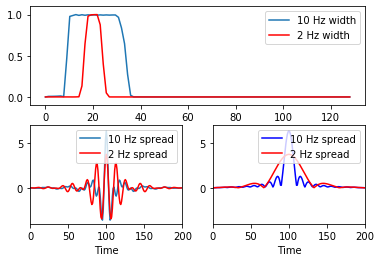

In [8]:
center_freq = 20 # in Hz
filter_frequency_spread_wide = 10 # Hz +/- the center frequency
filter_frequency_spread_naro =  2 # Hz +/- the center frequency

# construct filter kernels
ffrequencies   = np.array([ 0, 
                  (1-transition_width)*(center_freq-filter_frequency_spread_wide), 
                  (center_freq-filter_frequency_spread_wide),
                  (center_freq+filter_frequency_spread_wide),
                  (1+transition_width)*(center_freq+filter_frequency_spread_wide),
                  nyquist ])/nyquist
idealresponse  = np.array([ 0, 0, 1, 1, 0, 0, ])

filterweightsW = zscore(firls(201,ffrequencies,idealresponse))

ffrequencies   = np.array([ 0,
                  (1-transition_width)*(center_freq-filter_frequency_spread_naro),
                  (center_freq-filter_frequency_spread_naro),
                  (center_freq+filter_frequency_spread_naro),
                  (1+transition_width)*(center_freq+filter_frequency_spread_naro),
                  nyquist ])/nyquist;

filterweightsN = zscore(firls(201,ffrequencies,idealresponse))


plt.subplot(211)
fft_filtkern  = absolute(fft(filterweightsW))
fft_filtkern  = fft_filtkern/np.max(fft_filtkern) # normalized to 1.0 for visual comparison ease
plt.plot(hz_filtkern,fft_filtkern[:int(ceil(len(fft_filtkern)/2.))])

fft_filtkern  = absolute(fft(filterweightsN))
fft_filtkern  = fft_filtkern/np.max(fft_filtkern)# normalized to 1.0 for visual comparison ease
plt.plot(hz_filtkern,fft_filtkern[:int(ceil(len(fft_filtkern)/2.))],'r')
plt.setp(plt.gca(),'ylim',[-.1 ,1.1])
_=plt.legend(['10 Hz width','2 Hz width'])

plt.subplot(223)
plt.plot(filterweightsW)
plt.plot(filterweightsN,'r')
plt.setp(plt.gca(),'xlim',[0 ,200],'ylim',[-4 ,7])
plt.legend(['10 Hz spread','2 Hz spread'])
plt.xlabel('Time')

plt.subplot(224)
plt.plot(absolute(hilbert(filterweightsW)),'b')
plt.plot(absolute(hilbert(filterweightsN)),'r')
plt.setp(plt.gca(),'xlim',[0, 200],'ylim',[-4 ,7])
plt.legend(['10 Hz spread','2 Hz spread'])
_=plt.xlabel('Time')

### Figure 14.6

Relies on fir1() in matlab. I dont think there is an equivalent in scipy. I tried using scipy.firwin(), but the results don't seem to look the same. add this to the TODO.

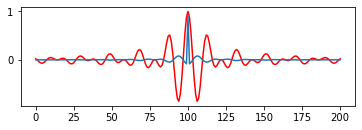

In [9]:
plt.subplot(211)


freqL = center_freq-filter_frequency_spread
freqU = center_freq+filter_frequency_spread

ffrequencies   =np.array( [ 0 ,freqL, freqL ,freqU, freqU ,nyquist ])/nyquist #transition zone of 0
filterweights  = firls(201,ffrequencies,idealresponse);
filterweights1 =  sig.firwin(201,np.array([freqL, freqU])/nyquist);


#plot wavelet and filter kernel
plt.plot(filterweights/np.max(filterweights),'r')
plt.plot(filterweights1)

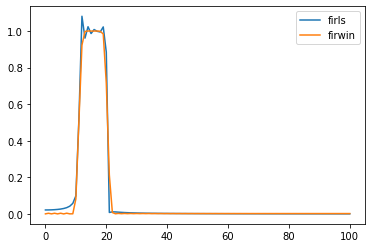

In [10]:
fft_filterweights1=1- absolute(fft(filterweights1))
fft_filterweights = absolute(fft(filterweights))

plt.plot(fft_filterweights[:int(ceil(len(filterweights)/2.))])
plt.plot(fft_filterweights1[:int(ceil(len(filterweights1)/2.))])

plt.legend(["firls","firwin"])

### Figure 14.7

Text(0.5, 1.0, 'SSE:1.8789420434559884e-09')

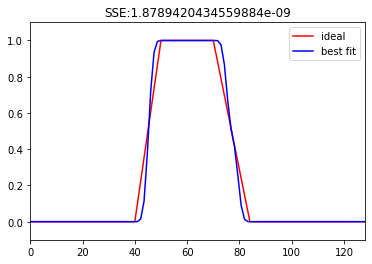

In [11]:
center_freq = 60. #in Hz
filter_frequency_spread_wide = 10 #Hz +- center frequency

ffrequencies = np.array([ 0,
                  (1-transition_width)*(center_freq-filter_frequency_spread_wide),
                  (center_freq-filter_frequency_spread_wide),
                  (center_freq+filter_frequency_spread_wide),
                  (1+transition_width)*(center_freq+filter_frequency_spread_wide),
                  nyquist ])/nyquist

idealresponse  = np.array([ 0, 0, 1 ,1, 0, 0 ])
filterweightsW = zscore(firls(201,ffrequencies,idealresponse))

plt.plot(ffrequencies*nyquist,idealresponse,'r')

fft_filtkern= absolute(fft(filterweightsW))
fft_filtkern = fft_filtkern/np.max(fft_filtkern) #normalized to 1 for visual comparison
plt.plot(hz_filtkern,fft_filtkern[:int(ceil(len(fft_filtkern)/2.))],'b')

plt.setp(plt.gca(),'ylim',[-.1,1.1],'xlim',[0, nyquist])
plt.legend(('ideal','best fit'))

#to replace the use of Matlab's dsearchn() function

def closest(X, p):
    disp = X - p
    return np.argmin((disp*disp))

freqsidx = [closest(hz_filtkern,x) for x in ffrequencies*nyquist]

plt.title("SSE:" + str(np.sum((idealresponse-fft_filtkern[freqsidx])**2)))

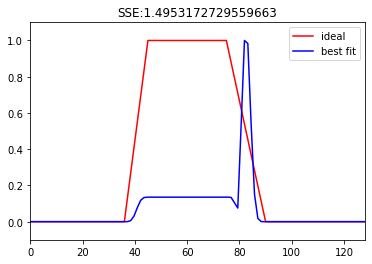

In [12]:
center_freq = 60 #in Hz
filter_frequency_spread_wide = 15 #Hz +-center frequency

ffrequencies = np.array([0,
                        (1-transition_width)*(center_freq-filter_frequency_spread_wide),
                        (center_freq - filter_frequency_spread_wide),
                        (center_freq+filter_frequency_spread_wide),
                        (1+transition_width)*(center_freq+filter_frequency_spread_wide),
                        nyquist])/nyquist

idealresponse  = np.array([ 0, 0, 1 ,1, 0, 0 ])
filterweightsW = zscore(firls(201,ffrequencies,idealresponse))

plt.plot(ffrequencies*nyquist,idealresponse,'r')

fft_filtkern= absolute(fft(filterweightsW))
fft_filtkern = fft_filtkern/np.max(fft_filtkern) #normalized to 1 for visual comparison
plt.plot(hz_filtkern,fft_filtkern[:int(ceil(len(fft_filtkern)/2.))],'b')

plt.setp(plt.gca(),'ylim',[-.1,1.1],'xlim',[0, nyquist])
plt.legend(('ideal','best fit'))

freqsidx = [closest(hz_filtkern,x) for x in ffrequencies*nyquist]

_=plt.title("SSE:" + str(np.sum((idealresponse-fft_filtkern[freqsidx])**2)))

### Figure 14.7b

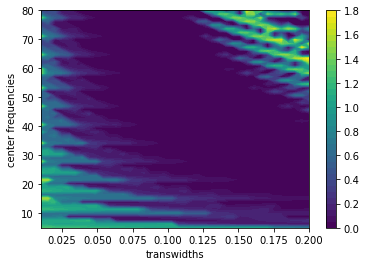

In [13]:
centerfreqs  = linspace(5,80,60)
transwidths  = linspace(0.01,0.2,40)
filterwidths = linspace(0.05,0.3,40)

sse = zeros((len(centerfreqs), len(transwidths)))
for centfreqi in range(len(centerfreqs)):
    
    center_freq = centerfreqs[centfreqi]
    filter_frequency_spread_wide = center_freq*.2

    for transwidi in range(len(transwidths)):
        
        transition_width = transwidths[transwidi]
        
        ffrequencies   = np.array([ 0,
                                  (1-transition_width)*(center_freq-filter_frequency_spread_wide),
                                  (center_freq-filter_frequency_spread_wide),
                                  (center_freq+filter_frequency_spread_wide),
                                  (1+transition_width)*(center_freq+filter_frequency_spread_wide),
                                  nyquist ])/nyquist

        filterweightsW = zscore(firls(201,ffrequencies,idealresponse))
        
        fft_filtkern   = absolute(fft(filterweightsW))
        fft_filtkern   = fft_filtkern/np.max(fft_filtkern) # normalized to 1.0 for visual comparison ease
        
        freqsidx = [closest(hz_filtkern,x) for x in ffrequencies*nyquist]
        
        sse[centfreqi,transwidi] = np.sum((idealresponse-fft_filtkern[freqsidx])**2 )


plt.contourf(transwidths,centerfreqs, sse, 40,
                )
plt.xlabel('transwidths'), plt.ylabel('center frequencies')
plt.colorbar()


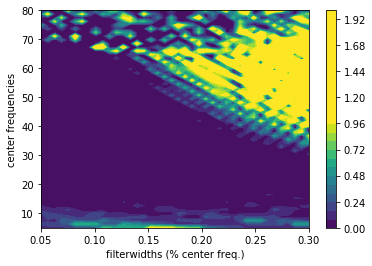

In [14]:
sse = zeros((len(centerfreqs),len(transwidths)));

for centfreqi in range(len(centerfreqs)):
    center_freq = centerfreqs[centfreqi]
    
    for transwidi in range(len(transwidths)):
        filter_frequency_spread_wide = center_freq*filterwidths[transwidi]
        transition_width = .2
        
        ffrequencies   = np.array([ 0,
                          (1-transition_width)*(center_freq-filter_frequency_spread_wide),
                          (center_freq-filter_frequency_spread_wide),
                          (center_freq+filter_frequency_spread_wide),
                          (1+transition_width)*(center_freq+filter_frequency_spread_wide),
                          nyquist ])/nyquist
        
        filterweightsW = zscore(firls(201,ffrequencies,idealresponse));

        fft_filtkern  = absolute(fft(filterweightsW));
        fft_filtkern  = fft_filtkern/np.max(fft_filtkern) # normalized to 1.0 for visual comparison ease
        
        freqsidx = [closest(hz_filtkern,x) for x in ffrequencies*nyquist]
        sse[centfreqi,transwidi] = np.sum( (idealresponse-fft_filtkern[freqsidx])**2)
        
        
plt.contourf(filterwidths,centerfreqs,sse,30)
plt.xlabel('filterwidths (% center freq.)')
plt.ylabel('center frequencies')
plt.colorbar()
plt.clim([0,1])

### Figure 14.8

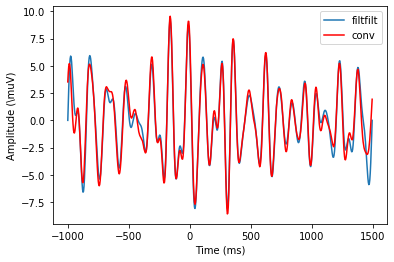

In [15]:

center_freq   = 10.
freqspread    = 4. #  Hz +/- the center frequency
transwid      = .10
ffrequencies  = np.array([ 0,
                          (1-transwid)*(center_freq-freqspread),
                          (center_freq-freqspread),
                          (center_freq+freqspread),
                          (1+transwid)*(center_freq+freqspread),
                          nyquist ])/nyquist

data2filter   = np.squeeze(EEGdata[46,:,0])
filterweights = firls(201,ffrequencies,idealresponse) # recompute without z-scoring

filter_result = sig.filtfilt(filterweights,1,data2filter)
convol_result = np.convolve(data2filter,filterweights,'same')# could also use ifft(fft(data2filter...


plt.plot(EEGtimes,filter_result)
plt.plot(EEGtimes,convol_result,'r')
# plt.setp(gca(),'xlim',[-200, 1000]) # zoom-in
plt.xlabel('Time (ms)'), plt.ylabel('Amplitude (\muV)')
_=plt.legend(['filtfilt','conv'])


### Figure 14.9

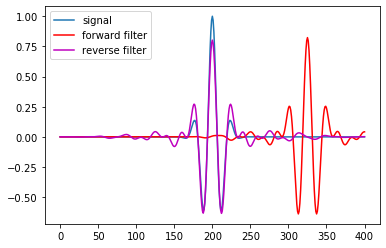

In [16]:

center_freq = 10 # in Hz
nyquist     = EEGsrate/2.;

# create short sine wave
time    = np.arange(-2000./EEGsrate/10.,2000./EEGsrate/10. + 1/EEGsrate,1/EEGsrate)
wavelet = cos(2*pi*center_freq*time) * exp(-time**2/(2*(3/(2*pi*center_freq))**2));


freqspread = 4. # Hz +/- the center frequency
transwid   = .10

# construct filter kernels
ffrequencies  = np.array([ 0 ,
                 (1-transwid)*(center_freq-freqspread),
                 (center_freq-freqspread) ,
                 (center_freq+freqspread),
                 (1+transwid)*(center_freq+freqspread),
                 nyquist ])/nyquist;
idealresponse = np.array([ 0 ,0 ,1, 1, 0, 0 ])
filterweights = firls(251,ffrequencies,idealresponse);


forward_filt = sig.lfilter(filterweights,1,wavelet)
reverse_filt = sig.lfilter(filterweights,1,forward_filt[::-1])
final_filt_result = reverse_filt[::-1] # must reverse time again!

plt.plot(wavelet)
plt.plot(forward_filt,'r')
plt.plot(reverse_filt,'m')

# plt.setp(gca(),'xlim',[0, len(wavelet)])
plt.legend(['signal','forward filter','reverse filter'])

### Figure 14.10

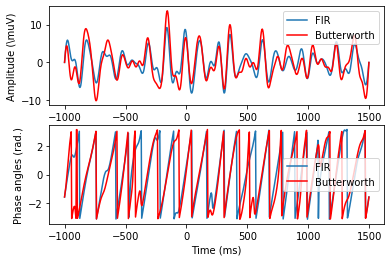

In [17]:

butterB,butterA = sig.butter(4,np.array([(center_freq-filter_frequency_spread),
                                         (center_freq+filter_frequency_spread)])/nyquist,btype='bandpass');
butter_filter = sig.filtfilt(butterB,butterA,data2filter,padlen=150);


plt.subplot(211)

#plot real part of the filtered signal
plt.plot(EEGtimes,filter_result)
plt.plot(EEGtimes,butter_filter,'r')
# plt.setp(gca(),'xlim',[-200, 1000])
plt.xlabel('Time (ms)'), plt.ylabel('Amplitude (\muV)');
plt.legend(['FIR','Butterworth'])

# now plot phases
plt.subplot(212)
plt.plot(EEGtimes,angle(hilbert(filter_result)))
plt.plot(EEGtimes,angle(hilbert(butter_filter)),'r')
# plt.setp(gca(),'xlim',[-200, 1000])
plt.xlabel('Time (ms)'), plt.ylabel('Phase angles (rad.)');
_=plt.legend(['FIR','Butterworth'])


### 14.12

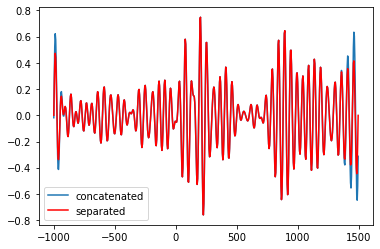

In [18]:
from time import time
elap_time = np.array([0., 0.])
num_iter  = 100

freqspread  =  4 # Hz +/- the center frequency
center_freq = 20.
transwid    = .15

#construct filter kernels
ffrequencies  = np.array([ 0,
                          (1-transwid)*(center_freq-freqspread),
                          (center_freq-freqspread) ,
                          (center_freq+freqspread) ,
                          (1+transwid)*(center_freq+freqspread) ,
                          nyquist ])/nyquist
idealresponse = np.array([ 0 ,0 ,1 ,1, 0 ,0 ])

filterweights = firls(3*np.round(EEGsrate/(center_freq-freqspread))+1,ffrequencies,idealresponse)


for i in range(num_iter):
    tic = time()
    data2filter_cat = np.squeeze(np.reshape(EEGdata[46,:,:],(1,EEGpnts*EEGtrials),order="F"))
    filtdat_cat = np.reshape(sig.filtfilt(filterweights,1,data2filter_cat),(EEGpnts,EEGtrials),order="F")
    elap_time[0] = elap_time[0] +( time() -tic)


for i in range(num_iter):
    tic = time()
    data2filter_sep = np.squeeze((EEGdata[46,:,:]))
    filtdat_sep = zeros(data2filter_sep.shape)
    for triali in range(EEGtrials):
        filtdat_sep[:,triali] = sig.filtfilt(filterweights,1,data2filter_sep[:,triali])
    
    elap_time[1] = elap_time[1] + (time() - tic)


elap_time = elap_time/num_iter

# plot
plt.plot(EEGtimes,np.mean(filtdat_cat,axis=1))
plt.plot(EEGtimes,np.mean(filtdat_sep,axis=1),'r')
plt.legend(['concatenated','separated'])


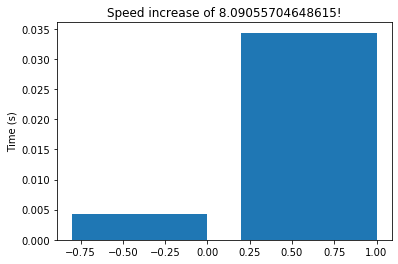

In [19]:
plt.bar([-.4,.6],elap_time)
# setp(gca(),'xlim',[-1,2],'xticks',[0,1],'xticklabels',['Concatenated','Separated'])
plt.ylabel('Time (s)')
_=plt.title( 'Speed increase of ' + str(elap_time[1]/elap_time[0]) + '!' )